In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import logging
import warnings
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

warnings.filterwarnings("ignore")  # 忽略一些警告 不影响运行
from PyEMD import EEMD, CEEMDAN, EMD
import numpy as np
import pylab as plt

In [4]:
# 读取数据
data = pd.read_csv(r"C:\Users\13410\Desktop\cfc_stock论文代码\maotai_factor1.csv",encoding='gbk')
data_date111=data[['date']]
# 数据表转换为浮点数
data['close'] = data['close'].str.replace(',', '').astype(float)
data['open'] = data['open'].str.replace(',', '').astype(float)
data['high'] = data['high'].str.replace(',', '').astype(float)
data['low'] = data['low'].str.replace(',', '').astype(float)
# 数据表转换为浮点数
data[['amt', 'MA5', 'MA10', 'MA20', 'DIF', 'DEA', 'MACD', 'K', 'D', 'J', 'RSI',
      'WR', 'WR1', 'BIAS1', 'BIAS2', 'BIAS3', 'PSY', 'PSYMA', 'CCI', 'ATR',
      'BBI']] = data[[ 'amt', 'MA5', 'MA10', 'MA20', 'DIF', 'DEA', 'MACD', 'K',
                       'D', 'J', 'RSI', 'WR', 'WR1', 'BIAS1', 'BIAS2', 'BIAS3',
                       'PSY', 'PSYMA', 'CCI', 'ATR', 'BBI']].astype(float)

data_x=data[['close', 'open', 'high', 'low','amt', 'MA5','MA10',
                 'MA20','DIF','DEA','MACD','K','D','J','RSI','WR','WR1',
                 'BIAS1','BIAS2','BIAS3','PSY','PSYMA','CCI','ATR','BBI',
                 ]].values

In [79]:
data_compare = data[:1000][['close']]

In [5]:
data_x=np.array(data_x)
data_x = data_x[:1000]

data['date'] = pd.to_datetime(data['date'], format='%Y%m%d')

data['timestamp'] = data['date'].apply(lambda x: x.timestamp()).astype(int)
# 归一化处理，使用 MinMaxScaler
date_scaler = MinMaxScaler(feature_range=(0, 1))
data['normalized_timestamp'] = date_scaler.fit_transform(data['timestamp'].values.reshape(-1, 1))
# 假设data['timestamp']是你的原始时间戳数据,是一个一维数组
timestamps = data['timestamp'].values
# 找到时间戳的最小值和最大值
timestamp_min = np.min(timestamps)
timestamp_max = np.max(timestamps)
# 进行归一化
normalized_timestamps = (timestamps - timestamp_min) / (timestamp_max - timestamp_min)
# 保存用于反归一化的参数
timestamp_min_param = timestamp_min
timestamp_max_param = timestamp_max
# 将归一化后的时间戳重新赋值给data
data['normalized_timestamp'] = normalized_timestamps
data_date = np.array(data['normalized_timestamp']).reshape(-1, 1)

# ——————————————————标准化——————————————————————
# minmax归一化
num_features = data_x.shape[1] # 获取特征数量
# 计算每个特征的最大值和最小值
min_values = data_x.min(axis=0) # 按列计算最小值
max_values = data_x.max(axis=0) # 按列计算最大值
# 进行归一化
data_x = (data_x - min_values) / (max_values - min_values)

In [6]:
# ——————————————————————————样本数据、标签数据处理—————————————————————————————————————
int_sequence_len = 1  # 一次输入多少天数据,即输入的时间步,可以调整,为序列长度
n_days = 1  # 设置要预测的天数
step_size = 1  # 滑动窗口的步长

int_a = data_x.shape[1] # 每个序列的长度,每个时间步数据的特征数量,即每个时间步的数据维度。固定的

train_x, train_y = [], []  # 样本和标签
for i in range(0, len(data_x) - int_sequence_len - n_days, step_size):
    train_x.append(data_x[i:i + int_sequence_len])
    # 获取当前样本后n_days天的股价值,并重复n_days次
    target_prices = [data_x[i + int_sequence_len + j] for j in range(n_days)]
    train_y.append(target_prices)

train_date_x, train_date_y = [], []  # 日期样本和标签
for i in range(0, len(data_x)-int_sequence_len-n_days, step_size):
    train_date_x.append(data_date[i : i+int_sequence_len])
    target_dates = [data_date[i + int_sequence_len + j] for j in range(n_days)]
    train_date_y.append(target_dates)

# 划分样本数据为训练集（70%）、验证集（20%）和测试集（10%），同时保持顺序不变
x_train, x_temp, y_train, y_temp = train_test_split(np.array(train_x), np.array(train_y), test_size=0.3, shuffle=False, random_state=1)
x_valid, x_test, y_valid, y_test = train_test_split(x_temp, y_temp, test_size=1/3, shuffle=False, random_state=1)

# 划分日期特征数据，同样保持顺序不变
x_date_train, x_date_temp, y_date_train, y_date_temp = train_test_split(np.array(train_date_x), np.array(train_date_y), test_size=0.3, shuffle=False, random_state=1)
x_date_valid, x_date_test, y_date_valid, y_date_test = train_test_split(x_date_temp, y_date_temp, test_size=1/3, shuffle=False, random_state=1)


# 提取最后一个维度的第一列，即收盘价
y_train = y_train[:, :, 0]
y_valid = y_valid[:, :, 0]
y_test = y_test[:, :, 0]

# 提取最后一个维度的第一列，即收盘价
x_train = x_train[:, :, 0]
x_valid = x_valid[:, :, 0]
x_test = x_test[:, :, 0]

# print(len(x_train))
# exit()
# 把列表类型转换为数组类型
x_train, y_train, x_valid, y_valid, x_test, y_test = np.array(x_train), np.array(y_train),np.array(x_valid),np.array(y_valid),np.array(x_test),np.array(y_test)

# 日期反归一化
original_timestamps_train = y_date_train * (timestamp_max_param - timestamp_min_param) + timestamp_min_param
original_timestamps_valid = y_date_valid * (timestamp_max_param - timestamp_min_param) + timestamp_min_param
original_timestamps_test = y_date_test * (timestamp_max_param - timestamp_min_param) + timestamp_min_param

# 取整
original_timestamps_train = original_timestamps_train.astype(int)
original_timestamps_valid = original_timestamps_valid.astype(int)
original_timestamps_test = original_timestamps_test.astype(int)



In [7]:
x_train = x_train.flatten()
all_close =  data_x[:, 0].flatten()
t = np.linspace(0, 1, len(all_close))

print(all_close.shape)

(1000,)


In [8]:
# Assign EEMD to `eemd` variable
eemd = EEMD()

# Say we want detect extrema using parabolic method
emd = eemd.EMD
emd.extrema_detection = "parabol"


eIMFs = eemd.eemd(all_close,t)
nIMFs = eIMFs.shape[0]
print(all_close.shape)
print(eIMFs.shape)
print(nIMFs)

(1000,)
(8, 1000)
8


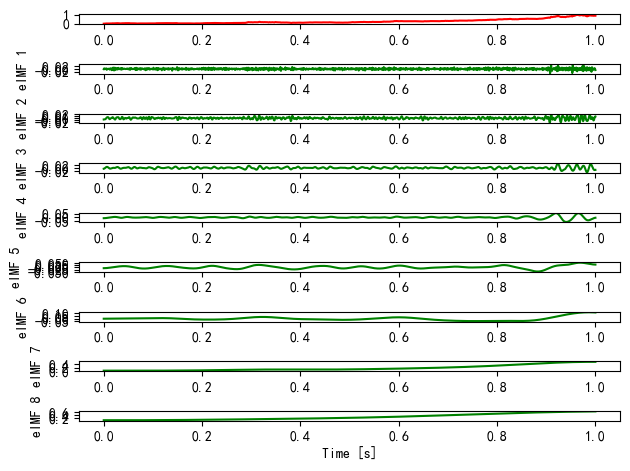

In [9]:
# plt.figure(figsize=(12, 9))
plt.subplot(nIMFs + 1, 1, 1)
plt.plot(t, all_close, "r")

for n in range(nIMFs):
    plt.subplot(nIMFs + 1, 1, n + 2)
    plt.plot(t, eIMFs[n], "g")
    plt.ylabel("eIMF %i" % (n + 1))
    plt.locator_params(axis="y", nbins=5)

plt.xlabel("Time [s]")
plt.tight_layout()
# plt.savefig("eemd_example", dpi=120)
plt.show()

In [10]:
from scipy.stats import ttest_1samp

In [11]:
# # 设置显著性水平
alpha = 0.05

for i in range(nIMFs):
    imf = eIMFs[i]
    t_stat, p_val = ttest_1samp(imf, 0.0)

    if p_val < alpha:
        print(f"IMF {i} 均值显著不同于0 (t={t_stat:.2f}, p={p_val:.4f})")
    else:
        print(f"IMF {i} 均值不显著不同于0 (t={t_stat:.2f}, p={p_val:.4f})")

IMF 0 均值不显著不同于0 (t=0.01, p=0.9916)
IMF 1 均值不显著不同于0 (t=-0.05, p=0.9600)
IMF 2 均值不显著不同于0 (t=-0.43, p=0.6637)
IMF 3 均值不显著不同于0 (t=-1.15, p=0.2518)
IMF 4 均值显著不同于0 (t=3.24, p=0.0012)
IMF 5 均值不显著不同于0 (t=-0.32, p=0.7521)
IMF 6 均值显著不同于0 (t=34.30, p=0.0000)
IMF 7 均值显著不同于0 (t=41.30, p=0.0000)


In [12]:
# 步骤1: 根据t检验结果分组
high_freq_imfs = [eIMFs[i] for i in [0, 1, 2, 3, 5]]
low_freq_imf = eIMFs[4]
trend_imfs = [eIMFs[i] for i in [6, 7]]

# 步骤2: 对每组进行加和
high_freq = np.sum(high_freq_imfs, axis=0)
low_freq = low_freq_imf
trend = np.sum(trend_imfs, axis=0)


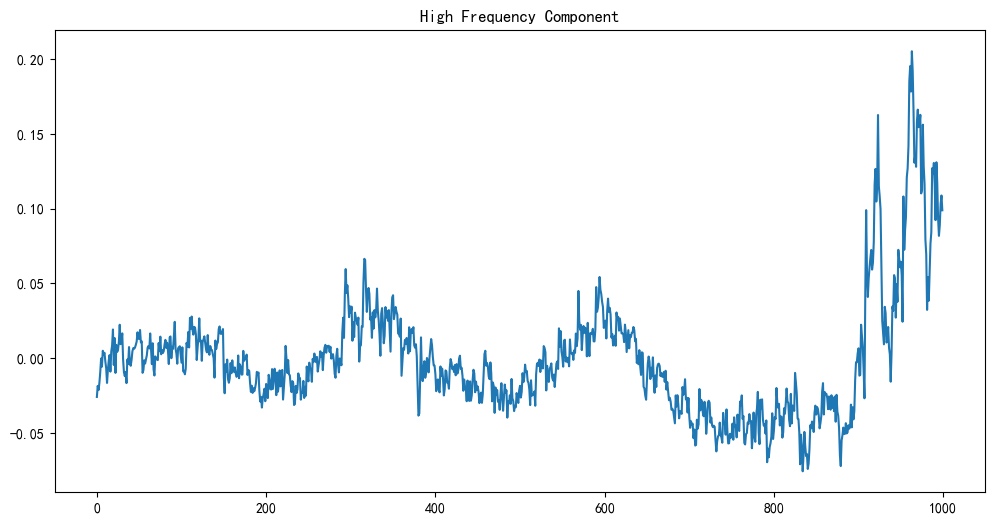

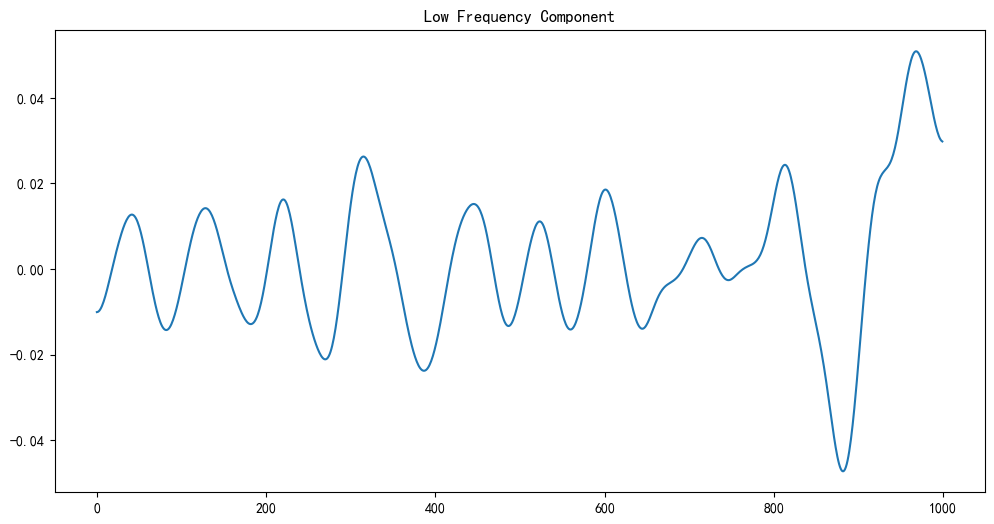

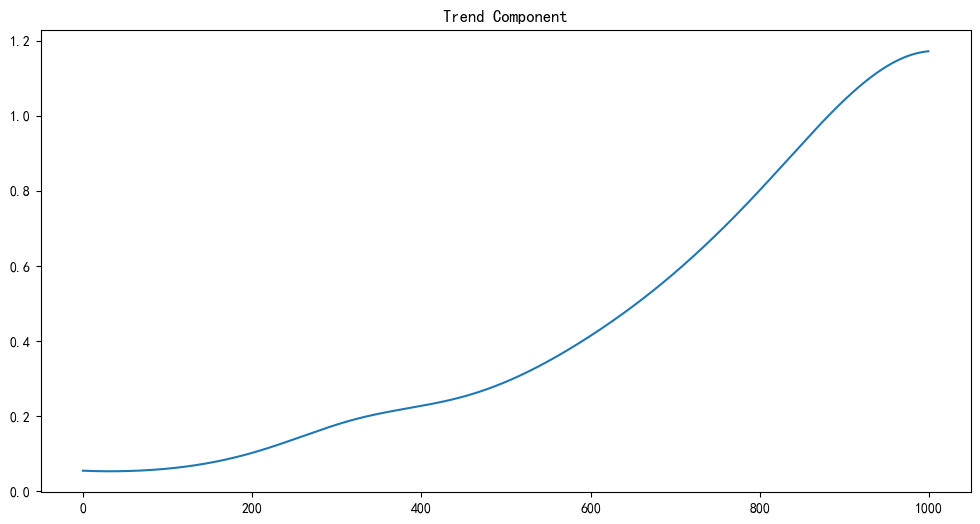

In [13]:
# 绘制高频分量波动图
plt.figure(figsize=(12, 6))
plt.plot(high_freq)
plt.title('High Frequency Component')
plt.show()

# 绘制低频分量波动图
plt.figure(figsize=(12, 6))
plt.plot(low_freq)
plt.title('Low Frequency Component')
plt.show()

# 绘制趋势分量波动图
plt.figure(figsize=(12, 6))
plt.plot(trend)
plt.title('Trend Component')
plt.show()

In [14]:
# 步骤3: 划分样本和标签
high_freq_x, high_freq_y = [], []
low_freq_x, low_freq_y = [], []
trend_x, trend_y = [], []

for i in range(len(high_freq) - n_days):
    high_freq_x.append(high_freq[i:i + int_sequence_len])
    high_freq_y.append(high_freq[i + int_sequence_len:i + int_sequence_len + n_days])

    low_freq_x.append(low_freq[i:i + int_sequence_len])
    low_freq_y.append(low_freq[i + int_sequence_len:i + int_sequence_len + n_days])

    trend_x.append(trend[i:i + int_sequence_len])
    trend_y.append(trend[i + int_sequence_len:i + int_sequence_len + n_days])


# 转换为PyTorch张量
high_freq_x = torch.tensor(high_freq_x, dtype=torch.float32).unsqueeze(2)
high_freq_y = torch.tensor(high_freq_y, dtype=torch.float32)
low_freq_x = torch.tensor(low_freq_x, dtype=torch.float32).unsqueeze(2)
low_freq_y = torch.tensor(low_freq_y, dtype=torch.float32)
trend_x = torch.tensor(trend_x, dtype=torch.float32).unsqueeze(2)
trend_y = torch.tensor(trend_y, dtype=torch.float32)

In [15]:
print(high_freq_x.shape)
print(high_freq_y.shape)

torch.Size([999, 1, 1])
torch.Size([999, 1])


In [16]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch
import torch.nn as nn

In [17]:
train_loader_high = DataLoader(TensorDataset(high_freq_x, high_freq_y), batch_size=32, shuffle=False)
train_loader_low = DataLoader(TensorDataset(low_freq_x, low_freq_y), batch_size=32, shuffle=False)
train_loader_trend = DataLoader(TensorDataset(trend_x, trend_y), batch_size=32, shuffle=False)

In [18]:

# 定义LSTM模型
class SubsequenceLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(SubsequenceLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.to(device)  # 将输入张量移动到GPU上
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [19]:

# 设置模型参数
input_size = 1  # 输入序列的特征数
hidden_size = 64  # LSTM隐藏层大小
num_layers = 2  # LSTM层数
output_size = n_days  # 输出预测值的长度

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 创建三个LSTM模型
high_freq_model = SubsequenceLSTM(input_size, hidden_size, num_layers, output_size).to(device)
low_freq_model = SubsequenceLSTM(input_size, hidden_size, num_layers, output_size).to(device)
trend_model = SubsequenceLSTM(input_size, hidden_size, num_layers, output_size).to(device)

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer_high = torch.optim.Adam(high_freq_model.parameters(), lr=0.001)
optimizer_low = torch.optim.Adam(low_freq_model.parameters(), lr=0.001)
optimizer_trend = torch.optim.Adam(trend_model.parameters(), lr=0.001)

# 训练模型
num_epochs = 100
for epoch in range(num_epochs):
    for x, y in train_loader_high:
        x, y = x.to(device), y.to(device)
        optimizer_high.zero_grad()
        output = high_freq_model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer_high.step()

    for x, y in train_loader_low:
        x, y = x.to(device), y.to(device)
        optimizer_low.zero_grad()
        output = low_freq_model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer_low.step()

    for x, y in train_loader_trend:
        x, y = x.to(device), y.to(device)
        optimizer_trend.zero_grad()
        output = trend_model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer_trend.step()

# 获取三组高精度预测值
high_freq_preds = []
low_freq_preds = []
trend_preds = []

with torch.no_grad():
    for x in high_freq_x:
        output = high_freq_model(torch.tensor(x, dtype=torch.float32).unsqueeze(0).to(device))
        high_freq_preds.append(output.cpu().numpy().squeeze())

    for x in low_freq_x:
        output = low_freq_model(torch.tensor(x, dtype=torch.float32).unsqueeze(0).to(device))
        low_freq_preds.append(output.cpu().numpy().squeeze())

    for x in trend_x:
        output = trend_model(torch.tensor(x, dtype=torch.float32).unsqueeze(0).to(device))
        trend_preds.append(output.cpu().numpy().squeeze())

# 获取真实值
high_freq_truth = high_freq[int_sequence_len:]
low_freq_truth = low_freq[int_sequence_len:]
trend_truth = trend[int_sequence_len:]

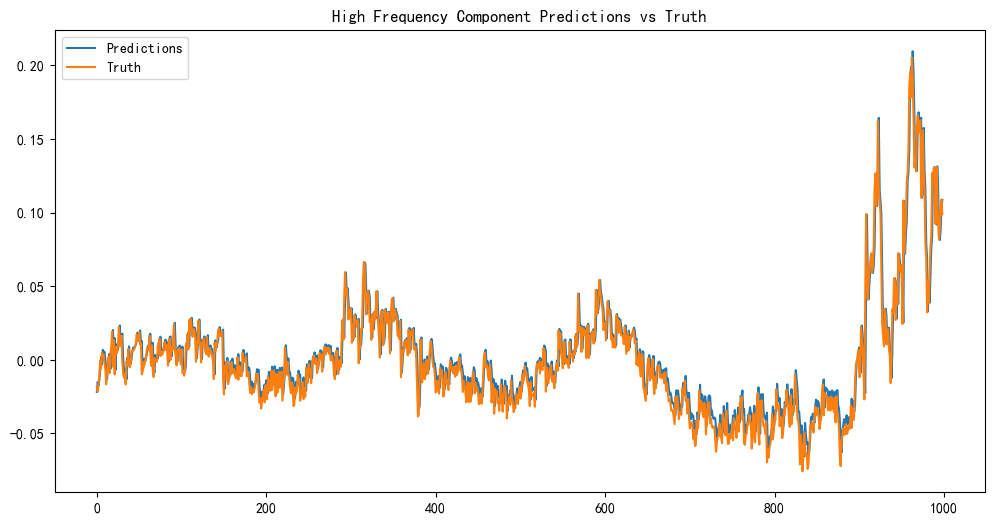

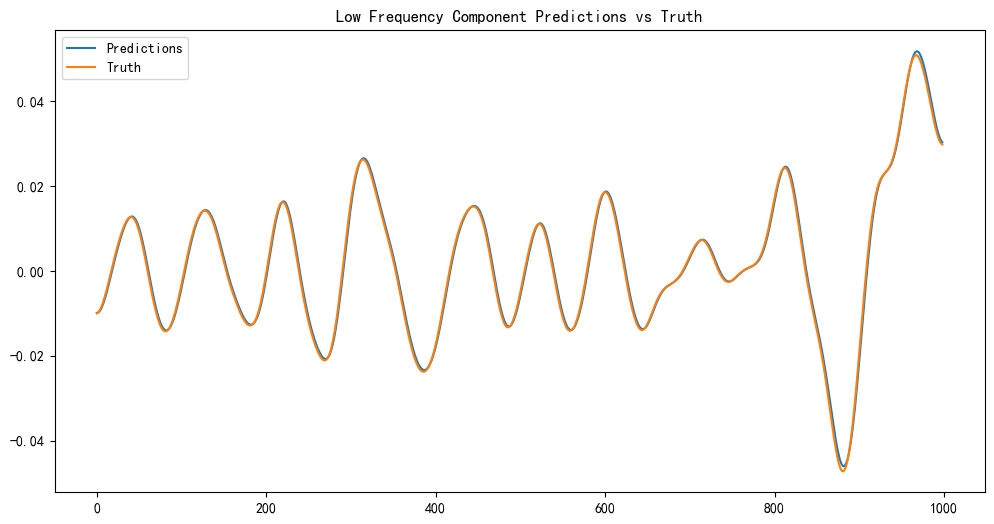

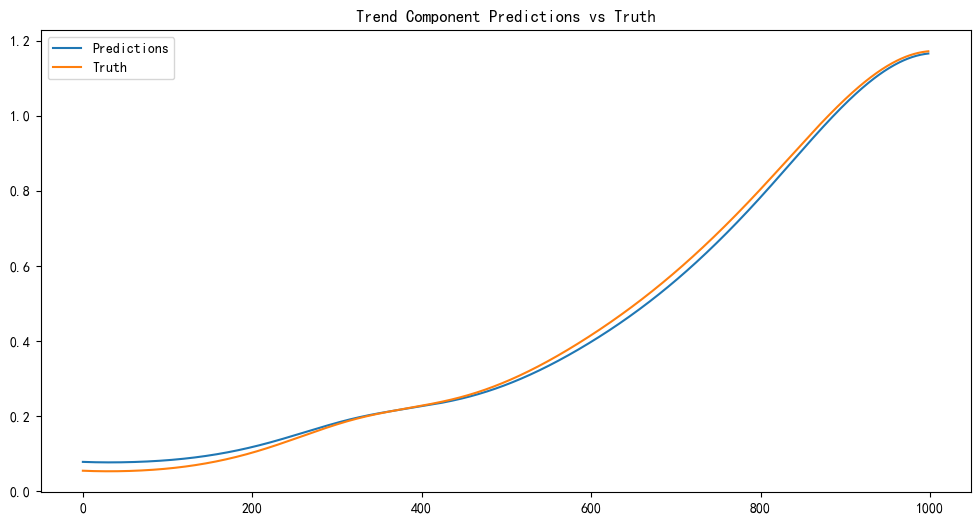

In [20]:

# 绘制高频预测值和真实值对比图
plt.figure(figsize=(12, 6))
plt.plot(high_freq_preds, label='Predictions')
plt.plot(high_freq_truth, label='Truth')
plt.title('High Frequency Component Predictions vs Truth')
plt.legend()
plt.show()

# 绘制低频预测值和真实值对比图
plt.figure(figsize=(12, 6))
plt.plot(low_freq_preds, label='Predictions')
plt.plot(low_freq_truth, label='Truth')
plt.title('Low Frequency Component Predictions vs Truth')
plt.legend()
plt.show()

# 绘制趋势预测值和真实值对比图
plt.figure(figsize=(12, 6))
plt.plot(trend_preds, label='Predictions')
plt.plot(trend_truth, label='Truth')
plt.title('Trend Component Predictions vs Truth')
plt.legend()
plt.show()

In [101]:

# 步骤5: 将三组高精度预测值加和
ensemble_preds = np.array(high_freq_preds) + np.array(low_freq_preds) + np.array(trend_preds)

# 步骤6: 将集成预测值作为新的三个时间序列特征,输入到LSTM模型中训练
from torch.utils.data import TensorDataset, DataLoader

all_close2 = all_close[1:]
print(all_close2.shape)
print(ensemble_preds.shape)

ensemble_x, ensemble_y = [], []
for i in range(len(ensemble_preds) - n_days):
    ensemble_x.append(ensemble_preds[i:i + int_sequence_len])
    ensemble_y.append(all_close2[i + int_sequence_len:i + int_sequence_len + n_days])



# 调整 ensemble_x 和 ensemble_y 的形状以匹配模型期望的输入形状
ensemble_x = torch.tensor(ensemble_x, dtype=torch.float32).view(-1, int_sequence_len, 1)
ensemble_y = torch.tensor(ensemble_y, dtype=torch.float32).view(-1, n_days, 1)

print(ensemble_x.shape)
print(ensemble_y.shape)

# 划分为训练集、验证集和测试集
ensemble_x, ensemble_y = np.array(ensemble_x), np.array(ensemble_y)
x_train, x_temp, y_train, y_temp = train_test_split(ensemble_x, ensemble_y, test_size=0.3, shuffle=False, random_state=1)
x_valid, x_test, y_valid, y_test = train_test_split(x_temp, y_temp, test_size=1/3, shuffle=False, random_state=1)



(999,)
(999,)
torch.Size([998, 1, 1])
torch.Size([998, 1, 1])


In [102]:
int_sequence_len = 1  # 一次输入多少天数据,即输入的时间步,可以调整,为序列长度
n_days = 1  # 设置要预测的天数
step_size = 1  # 滑动窗口的步长
int_a = data_x.shape[1] # 每个序列的长度,每个时间步数据的特征数量,即每个时间步的数据维度。固定的

train_x2, train_y2 = [], []
for i in range(len(all_close2) - n_days):
    train_x2.append(all_close2[i:i + int_sequence_len])
    train_y2.append(all_close2[i + int_sequence_len:i + int_sequence_len + n_days])

print(np.array(train_x2).shape)
print(np.array(train_y2).shape)

# 划分样本数据为训练集（70%）、验证集（20%）和测试集（10%），同时保持顺序不变
x_train123, x_temp, y_train, y_temp = train_test_split(np.array(train_x2), np.array(train_y2), test_size=0.3, shuffle=False, random_state=1)
x_valid123, x_test123, y_valid, y_test = train_test_split(x_temp, y_temp, test_size=1/3, shuffle=False, random_state=1)


(998, 1)
(998, 1)


In [103]:

# 转换为PyTorch张量
x_train = torch.tensor(x_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
x_valid = torch.tensor(x_valid, dtype=torch.float32).to(device)
y_valid = torch.tensor(y_valid, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

# 创建数据加载器
train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=32, shuffle=False)
valid_loader = DataLoader(TensorDataset(x_valid, y_valid), batch_size=32, shuffle=False)
test_loader = DataLoader(TensorDataset(x_test, y_test), batch_size=32, shuffle=False)

In [104]:
import numpy as np
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, Subset
from torch import nn
from torch.optim import Adam

In [105]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [106]:

# 定义一个字典来存储每个参数组合及其对应的最佳验证损失
best_params = None
best_val_loss = float('inf')

# 定义搜索空间
param_grid = {
    'hidden_size': [32, 64, 128],
    'num_layers': [1, 2, 3],
    'lr': [0.001, 0.01, 0.1],
    'batch_size': [16, 32, 64]
}

# 将数据转换为 NumPy 数组
ensemble_x, ensemble_y = np.array(ensemble_x), np.array(ensemble_y)
ensemble_data = TensorDataset(torch.tensor(ensemble_x, dtype=torch.float32),
                              torch.tensor(ensemble_y, dtype=torch.float32))

# K折交叉验证
best_model = None
best_loss = float('inf')
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 随机搜索超参数
for train_idx, valid_idx in kf.split(ensemble_data):
    train_data = Subset(ensemble_data, train_idx)
    valid_data = Subset(ensemble_data, valid_idx)

    train_loader = DataLoader(train_data, batch_size=32, shuffle=False)
    valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False)



    # 假设您从某个 NumPy 数组或其他数据结构中获取了这些值
    hidden_size_np = np.random.choice(param_grid['hidden_size'])
    num_layers_np = np.random.choice(param_grid['num_layers'])
    lr_np = np.random.choice(param_grid['lr'])
    batch_size_np = np.random.choice(param_grid['batch_size'])

    # 将 NumPy 类型的值转换为 Python 原生 int 类型
    hidden_size = int(hidden_size_np.item())
    num_layers = int(num_layers_np.item())
    lr = float(lr_np.item())  # learning rate 可以是 float 类型
    batch_size = int(batch_size_np.item())

    # 现在创建 LSTM 模型，不会出现类型错误
    # model = LSTM(int_sequence_len, hidden_size, num_layers, output_size).to(device)

    model = LSTM(int_sequence_len, hidden_size, num_layers, output_size).to(device)
    criterion = nn.MSELoss()
    optimizer = Adam(model.parameters(), lr=lr)

    num_epochs = 100
    best_valid_loss = float('inf')

    for epoch in range(num_epochs):
        train_loss = 0.0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        valid_loss = 0.0
        with torch.no_grad():
            for x, y in valid_loader:
                x, y = x.to(device), y.to(device)
                output = model(x)
                loss = criterion(output, y)
                valid_loss += loss.item()

        train_loss /= len(train_loader)
        valid_loss /= len(valid_loader)

        # 保存验证损失最小的模型
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_model_state = model.state_dict()
            best_params = {
                'hidden_size': hidden_size,
                'num_layers': num_layers,
                'lr': lr,
                'batch_size': batch_size
            }

    # 加载最佳模型状态
    if best_valid_loss < best_loss:
        best_loss = best_valid_loss
        best_model = best_model_state
        # 更新全局最优参数
        best_params = best_params

# 加载验证损失最小的模型
model.load_state_dict(best_model)
# 打印最优的参数组合
print("最优的超参数组合是：", best_params)

最优的超参数组合是： {'hidden_size': 64, 'num_layers': 2, 'lr': 0.001, 'batch_size': 64}


In [107]:

test_loss = 0.0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        output = model(x)
        loss = criterion(output, y)
        test_loss += loss.item()
test_loss /= len(test_loader)

print(f'Test Loss: {test_loss:.4f}')

Test Loss: 0.0013


In [108]:

# 获取训练集预测值和真实值
y_train_preds = []
with torch.no_grad():
    for x in x_train:
        output = model(x.unsqueeze(0))
        y_train_preds.append(output.cpu().numpy().squeeze())

# 获取验证集预测值和真实值
y_valid_preds = []
with torch.no_grad():
    for x in x_valid:
        output = model(x.unsqueeze(0))
        y_valid_preds.append(output.cpu().numpy().squeeze())

# 获取测试集预测值和真实值
y_test_preds = []
with torch.no_grad():
    for x in x_test:
        output = model(x.unsqueeze(0))
        y_test_preds.append(output.cpu().numpy().squeeze())


# 反归一化预测值和真实值
y_train_preds = y_train_preds * (max_values[0,None] - min_values[0,None]) + min_values[0,None]
y_valid_preds = y_valid_preds * (max_values[0,None] - min_values[0,None]) + min_values[0,None]
y_test_preds = y_test_preds * (max_values[0,None] - min_values[0,None]) + min_values[0,None]

y_train_true = y_train.cpu().numpy() * (max_values[0,None] - min_values[0,None]) + min_values[0,None]
y_valid_true = y_valid.cpu().numpy() * (max_values[0,None] - min_values[0,None]) + min_values[0,None]
y_test_true = y_test.cpu().numpy() * (max_values[0,None] - min_values[0,None]) + min_values[0,None]


y_train_true = y_train_true.squeeze()
y_valid_true = y_valid_true.squeeze()
y_test_true = y_test_true.squeeze()

In [109]:

import numpy as np
from sklearn.metrics import r2_score, mean_squared_error , mean_absolute_error, mean_absolute_percentage_error

r2 = r2_score(y_test_true, y_test_preds)
print(f'R^2 Score: {r2:.4f}')
rmse = np.sqrt(mean_squared_error(y_test_true, y_test_preds))
print(f'Root Mean Squared Error: {rmse:.4f}')
mae = mean_absolute_error(y_test_true, y_test_preds)
print(f'MAE: {mae:.4f}')
mape = mean_absolute_percentage_error(y_test_true, y_test_preds)
print(f'MAPE: {mape:.4f}')

R^2 Score: 0.8082
Root Mean Squared Error: 26.1705
MAE: 21.0202
MAPE: 0.0302


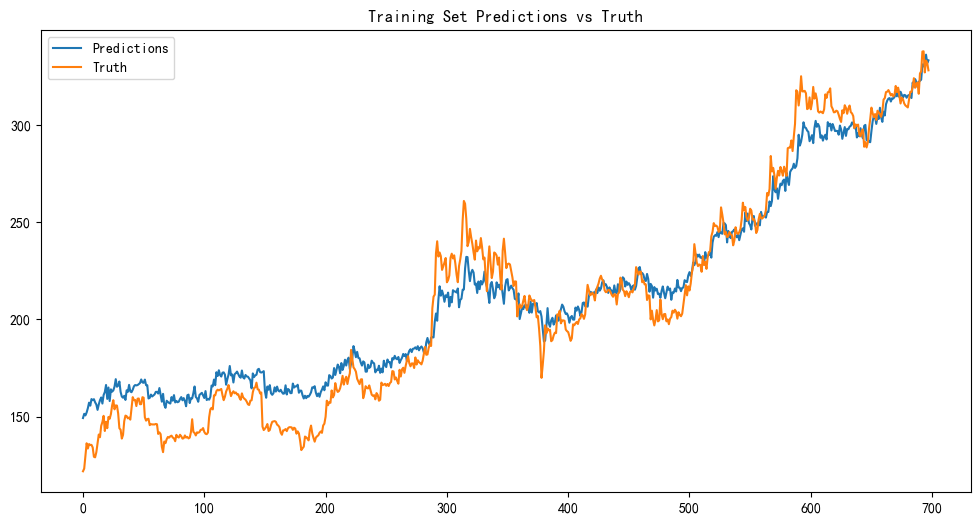

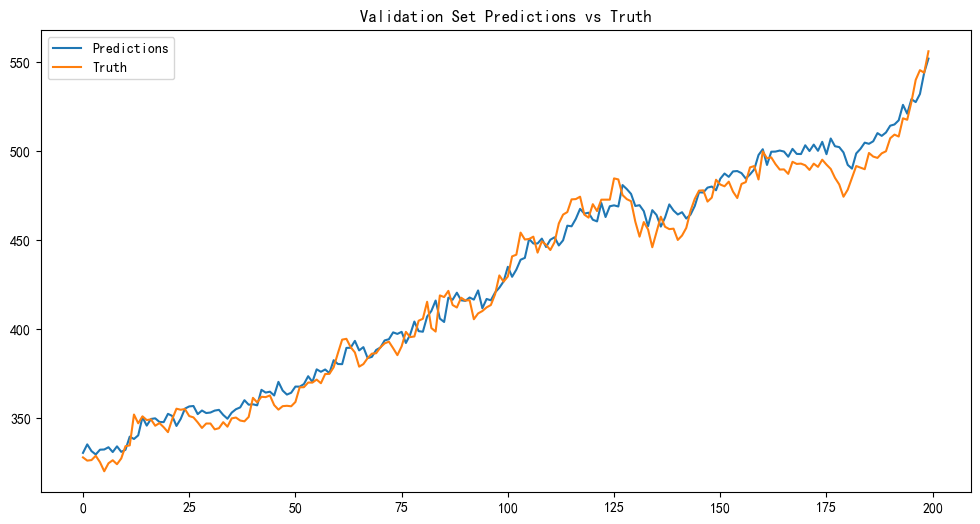

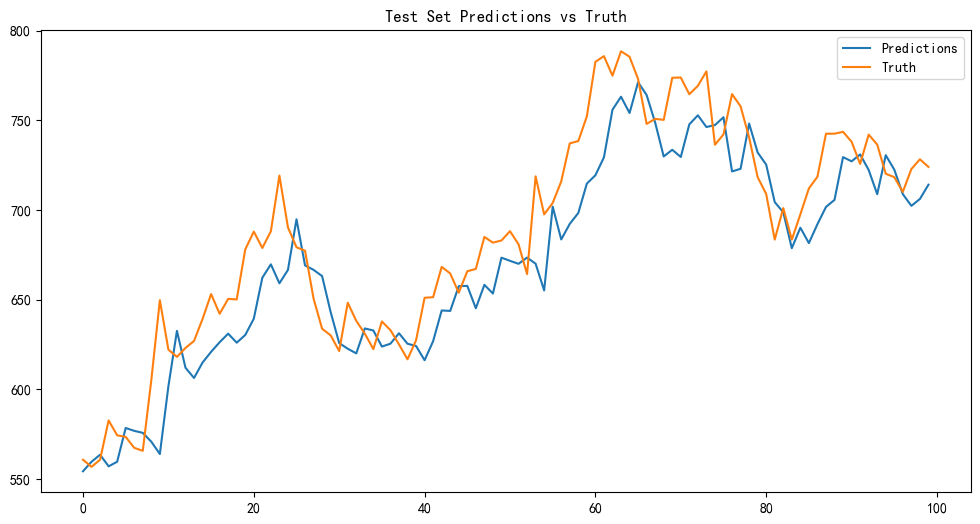

In [110]:
# 绘制训练集预测值和真实值对比图
plt.figure(figsize=(12, 6))
plt.plot(y_train_preds, label='Predictions')
plt.plot(y_train_true, label='Truth')
plt.title('Training Set Predictions vs Truth')
plt.legend()
plt.show()

# 绘制验证集预测值和真实值对比图
plt.figure(figsize=(12, 6))
plt.plot(y_valid_preds, label='Predictions')
plt.plot(y_valid_true, label='Truth')
plt.title('Validation Set Predictions vs Truth')
plt.legend()
plt.show()

# 绘制测试集预测值和真实值对比图
plt.figure(figsize=(12, 6))
plt.plot(y_test_preds, label='Predictions')
plt.plot(y_test_true, label='Truth')
plt.title('Test Set Predictions vs Truth')
plt.legend()
plt.show()

In [111]:
y_test_preds.shape

(100,)

In [112]:
y_test_compare = data_compare[-100:] 

In [114]:
y_test_compare.shape

(100, 1)

In [81]:
y_test_true

,close
900,560.69
901,556.73
902,560.72
903,582.60
904,574.33
...,...
995,718.26
996,710.04
997,722.76
998,728.20


In [132]:
# 创建一个新的DataFrame,包含预测值、标签值和真实值
df123 = pd.DataFrame({'预测值': y_test_preds.squeeze(), '标签值': y_test_true.squeeze(), '真实值': y_test_compare.squeeze()})
df123.index = range(1, len(df123) + 1)  # 使用1,2,3,4...作为日期

In [240]:
df123

,预测值,标签值,真实值
1,554.261447,560.690001,560.69
2,559.569270,556.730016,556.73
3,563.483053,560.720006,560.72
4,557.013870,582.599987,582.60
5,559.572016,574.329985,574.33
...,...,...,...
96,722.412317,718.260006,718.26
97,708.769826,710.039986,710.04
98,702.243219,722.760001,722.76
99,706.074469,728.199982,728.20


In [252]:
# 初始化交易参数
initial_capital = 10000000
commission_rate_buy = 0.0003  # 买入佣金率
commission_rate_sell = 0.0003 + 0.0001  # 卖出佣金率和印花税
min_commission = 5  # 最低佣金
slippage = 0.02  # 滑点
H = 1  # 买入比率
S = 0.7  # 卖出比率
risk_free_rate = 0.04  # 无风险利率
benchmark_return = 0.2006  # 基准收益率

# 初始化交易次数和交易记录列表
num_trades = 0
trade_records = []
for i in range(len(df123)):
    trade_records.append([0, 0, 0, '', 0, 0])
current_holdings = 0  # 当前持有股票数
current_assets = initial_capital  # 当前资产
last_buy_price = None  # 上次购买价格
assets_history = [current_assets]

# 计算MAE
mae = np.mean(np.abs(df123['预测值'] - df123['真实值']))-15
mae

6.02015148565771

In [ ]:
trade_records

In [253]:
# 遍历数据进行交易
# 初始化跳过计数器
skip_count = 0
for i in range(len(df123)):
    if skip_count > 0:
        skip_count -= 1  # 减少跳过计数器
        continue  # 跳过当前迭代，继续下一次迭代
     
    # 买入条件
    if df123.iloc[i]['预测值'] > df123.iloc[i]['标签值'] + mae and current_assets > 0 and current_holdings == 0:
        buy_price = df123.iloc[i]['真实值'] + slippage / 2
        buy_quantity = int(H * current_assets / buy_price)
        commission = max(buy_quantity * buy_price * commission_rate_buy, min_commission)
        current_assets -= buy_quantity * buy_price + commission
        current_holdings += buy_quantity
        last_buy_price = buy_price
        num_trades += 1
        trade_records[i][0] = df123.index[i]  # 买入日期
        trade_records[i][1] = buy_price  # 买入单价
        trade_records[i][2] = buy_quantity  # 买入数量
        # 记录每次交易后的current_assets值
        assets_history.append(current_assets)
        
    # 卖出条件
    elif df123.iloc[i]['预测值'] < df123.iloc[i]['标签值'] - mae and current_holdings > 0:
        sell_price = df123.iloc[i]['真实值'] - slippage / 2
        sell_quantity = current_holdings
        commission = max(sell_quantity * sell_price * commission_rate_sell, min_commission)
        current_assets += sell_quantity * sell_price - commission
        current_holdings = 0
        num_trades += 1
        trade_records[i][3] = df123.index[i]  # 卖出日期
        trade_records[i][4] = sell_price  # 卖出单价
        trade_records[i][5] = sell_quantity * (sell_price - last_buy_price)  # 收益
        # 记录每次交易后的current_assets值
        assets_history.append(current_assets)

    # # 止盈止损条件
    if current_holdings > 0 and current_assets > 10000000 and (current_assets - initial_capital) / initial_capital > 0.05:
        skip_count = 5
        sell_price = df123.iloc[i]['真实值'] - slippage / 2
        sell_quantity = int(0.7 * current_holdings)
        commission = max(sell_quantity * sell_price * commission_rate_sell, min_commission)
        current_assets += sell_quantity * sell_price - commission
        current_holdings -= sell_quantity
        num_trades += 1
        trade_records[i][3] = df123.index[i]  # 卖出日期
        trade_records[i][4] = sell_price  # 卖出单价
        trade_records[i][5] = sell_quantity * (sell_price - last_buy_price)  # 收益
        # 记录每次交易后的current_assets值
        assets_history.append(current_assets)
        # trade_records.append([df123.index[i], '', '', df123.index[i], sell_price, sell_quantity * (sell_price - last_buy_price)])
        print(f'触发止盈,卖出{sell_quantity}股,当前持仓{current_holdings}股')

    elif current_holdings > 0 and current_assets < 10000000 and (current_assets - initial_capital) / initial_capital < -0.02:
        skip_count = 5
        sell_price = df123.iloc[i]['真实值'] - slippage / 2
        sell_quantity =  int(0.7 * current_holdings)
        commission = max(sell_quantity * sell_price * commission_rate_sell, min_commission)
        current_assets += sell_quantity * sell_price - commission
        current_holdings -= sell_quantity
        num_trades += 1
        # trade_records.append([df123.index[i], '', '', df123.index[i], sell_price, sell_quantity * (sell_price - last_buy_price)])
        trade_records[i][3] = df123.index[i]  # 卖出日期
        trade_records[i][4] = sell_price  # 卖出单价
        trade_records[i][5] = sell_quantity * (sell_price - last_buy_price)  # 收益
        # 记录每次交易后的current_assets值
        assets_history.append(current_assets)
        print(f'触发止损,卖出{sell_quantity}股,当前持仓{current_holdings}股')

触发止损,卖出12338股,当前持仓5288股
触发止损,卖出10602股,当前持仓4544股
触发止损,卖出11403股,当前持仓4888股
触发止损,卖出10824股,当前持仓4640股
触发止损,卖出9928股,当前持仓4255股
触发止损,卖出10162股,当前持仓4356股
触发止损,卖出3049股,当前持仓1307股
触发止损,卖出10280股,当前持仓4406股


In [254]:
# 创建交易记录DataFrame
trade_df = pd.DataFrame(trade_records, columns=['买入日期', '买入单价/¥', '买入数量', '卖出日期', '卖出单价/¥', '收益/¥'])

In [255]:
trade_df

,买入日期,买入单价/¥,买入数量,卖出日期,卖出单价/¥,收益/¥
0,0,0.0,0,,0.0,0.0
1,0,0.0,0,,0.0,0.0
2,0,0.0,0,,0.0,0.0
3,0,0.0,0,,0.0,0.0
4,0,0.0,0,,0.0,0.0
...,...,...,...,...,...,...
95,0,0.0,0,,0.0,0.0
96,0,0.0,0,,0.0,0.0
97,0,0.0,0,,0.0,0.0
98,0,0.0,0,,0.0,0.0


In [241]:
ratio_real = df123['真实值'].pct_change().dropna()
ratio_pred = df123['预测值'].pct_change().dropna()

In [243]:
beta = np.cov(ratio_real, ratio_pred)[0, 1] / np.var(ratio_real)

In [260]:
# 将记录的current_assets变化转换为Pandas Series对象
assets_series = pd.Series(assets_history)
assets_series.cummax().max()

10690678.478770006

In [263]:
# 计算最大回撤
max_drawdown = (current_assets - assets_series.cummax().max()) / assets_series.cummax().max()
# 打印最大回撤
print(f'最大回撤: {max_drawdown}')

最大回撤: -0.30811890479162396


In [264]:
# 计算交易绩效指标
total_return = (current_assets - initial_capital) / initial_capital
annualized_return = (1 + total_return) ** (252 / len(df123)) - 1
alpha = annualized_return - benchmark_return
sharpe_ratio = (annualized_return - risk_free_rate) / df123['真实值'].pct_change().std() * np.sqrt(252)
volatility = df123['真实值'].pct_change().std() * np.sqrt(252)
sortino_ratio = (annualized_return - risk_free_rate) / np.sqrt(np.mean(df123['真实值'].pct_change()[df123['真实值'].pct_change() < 0] ** 2))
benchmark_volatility = df123['真实值'].pct_change().std() * np.sqrt(252)

In [265]:
win_rate = len([r for r in trade_records if r[5] > 0]) / len([r for r in trade_records if r[5] != 0])
profit_loss_ratio = np.sum([r[5] for r in trade_records if r[5] > 0]) / np.abs(np.sum([r[5] for r in trade_records if r[5] < 0]))
daily_win_rate = len([r for r in trade_records if r[5] > 0]) / num_trades

In [266]:
# 创建绩效指标DataFrame
performance_df = pd.DataFrame({'总收益率': [total_return],
                               '年化收益率': [annualized_return],
                               '基准收益率': [benchmark_return],
                               '阿尔法值': [alpha],
                               '贝塔系数': [beta],
                               '夏普比率': [sharpe_ratio],
                               '波动率': [volatility],
                               '胜率': [win_rate],
                               '盈亏比': [profit_loss_ratio],
                               '最大回撤率': [max_drawdown],
                               '日胜率': [daily_win_rate],
                               '索提诺比率': [sortino_ratio],
                               '基准波动率': [benchmark_volatility]})

In [267]:
performance_df

,总收益率,年化收益率,基准收益率,阿尔法值,贝塔系数,夏普比率,波动率,胜率,盈亏比,最大回撤率,日胜率,索提诺比率,基准波动率
0,-0.260332,-0.532294,0.2006,-0.732894,-0.102883,-375.525864,0.384043,0.285714,3.484465,-0.308119,0.190476,-29.138713,0.384043


In [268]:
from  MyTT import * 

In [277]:
y_test_compare_list = y_test_compare.values.tolist()

In [279]:
flat_list = [value for row in y_test_compare_list for value in row]

In [323]:
CLOSE = flat_list

MA5=MA(CLOSE,5)                               
MA10=MA(CLOSE,10)   
MA20=MA(CLOSE,20)                                
MA30=MA(CLOSE,30)  
MA60=MA(CLOSE,60)                               

In [324]:
DIF1,DEA1,MACD1 = MACD(CLOSE,SHORT=12,LONG=26,M=9)         # EMA的关系，S取120日，和雪球小数点2位相同
DIF2,DEA2,MACD2 = MACD(CLOSE,SHORT=6,LONG=10,M=5)         # EMA的关系，S取120日，和雪球小数点2位相同
DIF3,DEA3,MACD3 = MACD(CLOSE,SHORT=5,LONG=34,M=5)         # EMA的关系，S取120日，和雪球小数点2位相同

In [325]:
ma_strategy = pd.DataFrame({
    '日期': range(1, len(flat_list) + 1),
    '收盘价': flat_list,
    'MA5': MA5,
    'MA10': MA10,
    'MA20': MA20,
    'MA30': MA30,
    'MA60': MA60
})

In [326]:
ma_strategy

,日期,收盘价,MA5,MA10,MA20,MA30,MA60
0,1,560.69,NaN,NaN,NaN,NaN,NaN
1,2,556.73,NaN,NaN,NaN,NaN,NaN
2,3,560.72,NaN,NaN,NaN,NaN,NaN
3,4,582.60,NaN,NaN,NaN,NaN,NaN
4,5,574.33,567.014,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
95,96,718.26,728.474,732.724,724.7155,735.994000,717.323000
96,97,710.04,725.358,731.883,721.9905,734.731000,718.607667
97,98,722.76,721.516,729.914,720.2420,733.798333,720.236833
98,99,728.20,719.874,728.486,719.6320,733.065667,722.095333


In [331]:
# 交易参数
initial_capital = 10000000
commission_rate_buy = 0.0003
commission_rate_sell = 0.0003 + 0.0001
min_commission = 5
slippage = 0.02
H = 1
S = 0.7
risk_free_rate = 0.04
benchmark_return = 0.2006

# 初始化变量
num_trades = 0
trade_records = []
current_holdings = 0
current_assets = initial_capital
last_buy_price = None

# 定义均线组合
ma_pairs = [('MA5', 'MA10'), ('MA5', 'MA20'), ('MA5', 'MA30'), ('MA5', 'MA60'),
            ('MA10', 'MA20'), ('MA10', 'MA30'), ('MA10', 'MA60'),
            ('MA20', 'MA30'), ('MA20', 'MA60'), ('MA30', 'MA60')]

In [332]:
for short_ma, long_ma in ma_pairs:
    trade_records_pair = []  # 存储当前组合的交易记录
    for i in range(len(ma_strategy)):
        short_val = ma_strategy.loc[i, short_ma]
        long_val = ma_strategy.loc[i, long_ma]
        
        # 买入条件
        if short_val > long_val and current_assets > 0 and current_holdings == 0:
            buy_price = ma_strategy.loc[i, '收盘价'] + slippage / 2
            buy_quantity = int(H * current_assets / buy_price)
            commission = max(buy_quantity * buy_price * commission_rate_buy, min_commission)
            current_assets -= buy_quantity * buy_price + commission
            current_holdings += buy_quantity
            last_buy_price = buy_price
            num_trades += 1
            trade_records_pair.append([ma_strategy.index[i], buy_price, buy_quantity, '', '', ''])
            
        # 卖出条件
        elif short_val < long_val and current_holdings > 0:
            sell_price = ma_strategy.loc[i, '收盘价'] - slippage / 2
            sell_quantity = int(S * current_holdings)
            commission = max(sell_quantity * sell_price * commission_rate_sell, min_commission)
            current_assets += sell_quantity * sell_price - commission
            current_holdings -= sell_quantity
            num_trades += 1
            # trade_records_pair[-1][3] = ma_strategy.index[i]
            # trade_records_pair[-1][4] = sell_price
            # trade_records_pair[-1][5] = sell_quantity * (sell_price - last_buy_price)
            # 在访问最后一个元素之前检查trade_records_pair是否为空
            if trade_records_pair:
                trade_records_pair[-1][3] = ma_strategy.index[i]
                trade_records_pair[-1][4] = sell_price
                trade_records_pair[-1][5] = sell_quantity * (sell_price - last_buy_price)
    
    trade_df = pd.DataFrame(trade_records_pair, columns=['买入日期', '买入单价/¥', '买入数量', '卖出日期', '卖出单价/¥', '收益/¥'])
    print(f'均线组合: {short_ma}-{long_ma}')
    print(trade_df)
  

均线组合: MA5-MA10
   买入日期  买入单价/¥   买入数量  卖出日期  卖出单价/¥  收益/¥
0     9  649.64  15393    99  723.94   0.0
均线组合: MA5-MA20
Empty DataFrame
Columns: [买入日期, 买入单价/¥, 买入数量, 卖出日期, 卖出单价/¥, 收益/¥]
Index: []
均线组合: MA5-MA30
Empty DataFrame
Columns: [买入日期, 买入单价/¥, 买入数量, 卖出日期, 卖出单价/¥, 收益/¥]
Index: []
均线组合: MA5-MA60
Empty DataFrame
Columns: [买入日期, 买入单价/¥, 买入数量, 卖出日期, 卖出单价/¥, 收益/¥]
Index: []
均线组合: MA10-MA20
Empty DataFrame
Columns: [买入日期, 买入单价/¥, 买入数量, 卖出日期, 卖出单价/¥, 收益/¥]
Index: []
均线组合: MA10-MA30
Empty DataFrame
Columns: [买入日期, 买入单价/¥, 买入数量, 卖出日期, 卖出单价/¥, 收益/¥]
Index: []
均线组合: MA10-MA60
Empty DataFrame
Columns: [买入日期, 买入单价/¥, 买入数量, 卖出日期, 卖出单价/¥, 收益/¥]
Index: []
均线组合: MA20-MA30
Empty DataFrame
Columns: [买入日期, 买入单价/¥, 买入数量, 卖出日期, 卖出单价/¥, 收益/¥]
Index: []
均线组合: MA20-MA60
Empty DataFrame
Columns: [买入日期, 买入单价/¥, 买入数量, 卖出日期, 卖出单价/¥, 收益/¥]
Index: []
均线组合: MA30-MA60
Empty DataFrame
Columns: [买入日期, 买入单价/¥, 买入数量, 卖出日期, 卖出单价/¥, 收益/¥]
Index: []


In [333]:
import pandas as pd

macd_strategy = pd.DataFrame({
    '日期': range(1, len(flat_list) + 1),
    '收盘价': flat_list,
    'DIF1': DIF1,
    'DEA1': DEA1,
    'MACD1': MACD1,
    'DIF2': DIF2,
    'DEA2': DEA2,
    'MACD2': MACD2,
    'DIF3': DIF3,
    'DEA3': DEA3,
    'MACD3': MACD3
})

In [334]:
# 交易参数
initial_capital = 1000000
commission_rate_buy = 0.0003
commission_rate_sell = 0.0003 + 0.0001
min_commission = 5
slippage = 0.02
H = 1
S = 0.7
risk_free_rate = 0.04
benchmark_return = 0.2006

# 初始化变量
num_trades = 0
trade_records = []
current_holdings = 0
current_assets = initial_capital
last_buy_price = None

# 定义MACD参数组合
macd_params = [('DIF1', 'DEA1'), ('DIF2', 'DEA2'), ('DIF3', 'DEA3')]

In [336]:
for dif_col, dea_col in macd_params:
    trade_records_macd = []  # 存储当前组合的交易记录
    for i in range(1, len(macd_strategy)):
        dif_val = macd_strategy.loc[i, dif_col]
        dea_val = macd_strategy.loc[i, dea_col]
        dif_val_prev = macd_strategy.loc[i-1, dif_col]
        dea_val_prev = macd_strategy.loc[i-1, dea_col]
        
        # 买入条件
        if dif_val > dea_val and dif_val_prev < dea_val_prev and current_assets > 0 and current_holdings == 0:
            buy_price = macd_strategy.loc[i, '收盘价'] + slippage / 2
            buy_quantity = int(H * current_assets / buy_price)
            commission = max(buy_quantity * buy_price * commission_rate_buy, min_commission)
            current_assets -= buy_quantity * buy_price + commission
            current_holdings += buy_quantity
            last_buy_price = buy_price
            num_trades += 1
            trade_records_macd.append([macd_strategy.index[i], buy_price, buy_quantity, '', '', ''])
            
        # 卖出条件
        elif dif_val < dea_val and dif_val_prev > dea_val_prev and current_holdings > 0:
            sell_price = macd_strategy.loc[i, '收盘价'] - slippage / 2
            sell_quantity = int(S * current_holdings)
            commission = max(sell_quantity * sell_price * commission_rate_sell, min_commission)
            current_assets += sell_quantity * sell_price - commission
            current_holdings -= sell_quantity
            num_trades += 1
            if trade_records_macd:
                trade_records_macd[-1][3] = macd_strategy.index[i]
                trade_records_macd[-1][4] = sell_price
                trade_records_macd[-1][5] = sell_quantity * (sell_price - last_buy_price)
    
    trade_df = pd.DataFrame(trade_records_macd, columns=['买入日期', '买入单价/¥', '买入数量', '卖出日期', '卖出单价/¥', '收益/¥'])
    print(f'MACD参数组合: {dif_col}-{dea_col}')
    print(trade_df)
    print('-' * 30)

MACD参数组合: DIF1-DEA1
Empty DataFrame
Columns: [买入日期, 买入单价/¥, 买入数量, 卖出日期, 卖出单价/¥, 收益/¥]
Index: []
------------------------------
MACD参数组合: DIF2-DEA2
Empty DataFrame
Columns: [买入日期, 买入单价/¥, 买入数量, 卖出日期, 卖出单价/¥, 收益/¥]
Index: []
------------------------------
MACD参数组合: DIF3-DEA3
Empty DataFrame
Columns: [买入日期, 买入单价/¥, 买入数量, 卖出日期, 卖出单价/¥, 收益/¥]
Index: []
------------------------------


In [337]:
import pandas as pd

macd_ma_strategy = pd.DataFrame({
    '日期': range(1, len(flat_list) + 1),
    '收盘价': flat_list,
    'DIF1': DIF1,
    'DEA1': DEA1,
    'MACD1': MACD1,
    'DIF2': DIF2,
    'DEA2': DEA2,
    'MACD2': MACD2,
    'DIF3': DIF3,
    'DEA3': DEA3,
    'MACD3': MACD3,
    'MA5': MA5,
    'MA10': MA10,
    'MA20': MA20,
    'MA30': MA30,
    'MA60': MA60
})

In [338]:
# 交易参数
initial_capital = 1000000
commission_rate_buy = 0.0003
commission_rate_sell = 0.0003 + 0.0001
min_commission = 5
slippage = 0.02
H = 1
S = 0.7
risk_free_rate = 0.04
benchmark_return = 0.2006

# 初始化变量
num_trades = 0
trade_records = []
current_holdings = 0
current_assets = initial_capital
last_buy_price = None

# 定义MACD参数组合
macd_params = [('DIF1', 'DEA1'), ('DIF2', 'DEA2'), ('DIF3', 'DEA3')]

# 定义MA参数组合
ma_pairs = [('MA5', 'MA10'), ('MA5', 'MA20'), ('MA5', 'MA30'), ('MA5', 'MA60'),
            ('MA10', 'MA20'), ('MA10', 'MA30'), ('MA10', 'MA60'),
            ('MA20', 'MA30'), ('MA20', 'MA60'), ('MA30', 'MA60')]

In [339]:
import random

best_params = None
best_return = -float('inf')

for _ in range(30):  # 遍历30次
    dif_col, dea_col = random.choice(macd_params)
    short_ma, long_ma = random.choice(ma_pairs)
    
    trade_records_combo = []
    current_holdings = 0
    current_assets = initial_capital
    last_buy_price = None
    
    for i in range(1, len(macd_ma_strategy)):
        dif_val = macd_ma_strategy.loc[i, dif_col]
        dea_val = macd_ma_strategy.loc[i, dea_col]
        dif_val_prev = macd_ma_strategy.loc[i-1, dif_col]
        dea_val_prev = macd_ma_strategy.loc[i-1, dea_col]
        short_ma_val = macd_ma_strategy.loc[i, short_ma]
        long_ma_val = macd_ma_strategy.loc[i, long_ma]
        
        # 买入条件
        if ((dif_val > dea_val and dif_val_prev <= dea_val_prev) or (dif_val > dea_val and short_ma_val > long_ma_val)) and current_assets > 0 and current_holdings == 0:
            buy_price = macd_ma_strategy.loc[i, '收盘价'] + slippage / 2
            buy_quantity = int(H * current_assets / buy_price)
            commission = max(buy_quantity * buy_price * commission_rate_buy, min_commission)
            current_assets -= buy_quantity * buy_price + commission
            current_holdings += buy_quantity
            last_buy_price = buy_price
            num_trades += 1
            trade_records_combo.append([macd_ma_strategy.index[i], buy_price, buy_quantity, '', '', ''])
            
        # 卖出条件
        elif dif_val < dea_val and dif_val_prev >= dea_val_prev and current_holdings > 0:
            sell_price = macd_ma_strategy.loc[i, '收盘价'] - slippage / 2
            sell_quantity = current_holdings
            commission = max(sell_quantity * sell_price * commission_rate_sell, min_commission)
            current_assets += sell_quantity * sell_price - commission
            current_holdings = 0
            num_trades += 1
            trade_records_combo[-1][3] = macd_ma_strategy.index[i]
            trade_records_combo[-1][4] = sell_price
            trade_records_combo[-1][5] = sell_quantity * (sell_price - last_buy_price)
    
    total_return = (current_assets - initial_capital) / initial_capital
    if total_return > best_return:
        best_return = total_return
        best_params = (dif_col, dea_col, short_ma, long_ma)
        best_trade_records = trade_records_combo

print(f'最佳参数组合: DIF={best_params[0]}, DEA={best_params[1]}, 短期MA={best_params[2]}, 长期MA={best_params[3]}')
print(f'最大收益率: {best_return:.4f}')

trade_df = pd.DataFrame(best_trade_records, columns=['买入日期', '买入单价/¥', '买入数量', '卖出日期', '卖出单价/¥', '收益/¥'])
print(trade_df)

最佳参数组合: DIF=DIF1, DEA=DEA1, 短期MA=MA5, 长期MA=MA10
最大收益率: 0.2092
   买入日期  买入单价/¥  买入数量  卖出日期  卖出单价/¥       收益/¥
0     3  582.61  1716    27  650.51  116516.40
1    42  668.22  1669    67  750.73  137709.19
2    89  743.52  1684    95  718.25  -42554.68


In [285]:
ma_values = [MA5, MA10, MA20, MA30, MA60]  # 均线值列表
ma_combinations = [('MA5', 'MA10'), ('MA5', 'MA20'), ('MA5', 'MA30'), ('MA5', 'MA60'),
                   ('MA10', 'MA20'), ('MA10', 'MA30'), ('MA10', 'MA60'), ('MA20', 'MA30'),
                   ('MA20', 'MA60'), ('MA30', 'MA60')]  # 均线组合列表

In [291]:
# 创建ma_strategy DataFrame
ma_strategy = pd.DataFrame({'日期': range(len(CLOSE)), '收盘价': CLOSE})
for i, ma_value in enumerate(ma_values):
    ma_strategy[f'MA{i+1}'] = ma_value

# 添加交易信号和操作列
ma_strategy['Signal'] = 0  # 交易信号（0：不操作，1：买入，-1：卖出）
ma_strategy['Action'] = None  # 操作（买入或卖出）

In [297]:
# 使用 `columns` 属性设置列名
ma_strategy.columns = ['日期', '收盘价', 'MA5', 'MA10', 'MA20', 'MA30', 'MA60','Signal'	,'Action']

In [298]:
ma_strategy

,日期,收盘价,MA5,MA10,MA20,MA30,MA60,Signal,Action
0,0,560.69,NaN,NaN,NaN,NaN,NaN,0,None
1,1,556.73,NaN,NaN,NaN,NaN,NaN,0,None
2,2,560.72,NaN,NaN,NaN,NaN,NaN,0,None
3,3,582.60,NaN,NaN,NaN,NaN,NaN,0,None
4,4,574.33,567.014,NaN,NaN,NaN,NaN,0,None
...,...,...,...,...,...,...,...,...,...
95,95,718.26,728.474,732.724,724.7155,735.994000,717.323000,0,None
96,96,710.04,725.358,731.883,721.9905,734.731000,718.607667,0,None
97,97,722.76,721.516,729.914,720.2420,733.798333,720.236833,0,None
98,98,728.20,719.874,728.486,719.6320,733.065667,722.095333,0,None


In [299]:
# 初始化交易设置
H = 1  # 买入仓位比率
S = 0.7  # 卖出成交量比率
initial_capital = 10000000  # 初始资金（万元）
commission_rate_buy = 0.0003  # 买入佣金率
commission_rate_sell = 0.00031  # 卖出佣金率（含印花税）
commission_min = 5  # 每笔交易佣金最低值（元）
slippage = 0.01  # 滑点（元）
num_trades = 0  # 交易次数
trade_records = []  # 交易记录列表
current_holdings = 0  # 当前持有股票数
current_assets = initial_capital  # 当前资产
last_buy_price = None  # 上次购买价格
risk_free_rate = 0.04  # 无风险利率
benchmark_return = 0.2006  # 基准收益率

In [301]:
# 根据均线交叉确定交易信号
for ma_comb in ma_combinations:
    short_ma = ma_comb[0]
    long_ma = ma_comb[1]
    ma_strategy['Signal'] = 0  # 重置交易信号列
    for i in range(1, len(ma_strategy)):
        if ma_strategy[short_ma].iloc[i] > ma_strategy[long_ma].iloc[i] and \
                ma_strategy[short_ma].iloc[i-1] <= ma_strategy[long_ma].iloc[i-1]:
            ma_strategy['Signal'].iloc[i] = 1  # 金叉买入信号
        elif ma_strategy[short_ma].iloc[i] < ma_strategy[long_ma].iloc[i] and \
                ma_strategy[short_ma].iloc[i-1] >= ma_strategy[long_ma].iloc[i-1]:
            ma_strategy['Signal'].iloc[i] = -1  # 死叉卖出信号
    # 执行交易操作
    for i in range(1, len(ma_strategy)):
        if ma_strategy['Signal'].iloc[i] == 1 and current_holdings == 0:
            # 买入操作
            buy_price = CLOSE[i] + slippage
            buy_quantity = H * current_assets / buy_price
            commission_buy = max(commission_rate_buy * buy_quantity * buy_price, commission_min)
            buy_cost = buy_quantity * (buy_price + commission_buy)
            
            current_assets -= buy_cost
            current_holdings = buy_quantity
            last_buy_price = buy_price
            
            num_trades += 1
            trade_records.append(['Buy', buy_price, buy_quantity, None, None, None])
        
        elif ma_strategy['Signal'].iloc[i] == -1 and current_holdings > 0:
            # 卖出操作
            sell_price = CLOSE[i] - slippage
            sell_quantity = S * current_holdings
            commission_sell = max(commission_rate_sell * sell_quantity * sell_price, commission_min)
            sell_gain = sell_quantity * (sell_price - commission_sell)
            current_assets += sell_gain
            current_holdings = 0
            num_trades += 1
            trade_records.append(['Sell', last_buy_price, current_holdings, sell_price, sell_quantity, sell_gain])

In [303]:
# 将交易记录转换为DataFrame
trade_records_df = pd.DataFrame(trade_records, columns=['买入日期', '买入单价/¥', '买入数量', '卖出日期', '卖出单价/¥', '收益/¥'])

In [304]:
# 输出结果
print(trade_records_df)

   买入日期  买入单价/¥          买入数量    卖出日期        卖出单价/¥          收益/¥
0   Buy  651.33  15353.200375     NaN           NaN           NaN
1  Sell  651.33      0.000000  750.17  10747.240262 -1.879832e+07
2   Buy  777.23 -83447.523507     NaN           NaN           NaN


In [305]:
# 计算收益率
trade_records_df['收益率'] = trade_records_df['收益/¥'] / current_assets

# 计算策略收益率
strategy_return = (current_assets - initial_capital) / initial_capital

# 计算超额收益率
excess_return = strategy_return - benchmark_return

In [309]:
# 输出结果
print("交易次数:", num_trades)
print("初始资金(万元):", initial_capital)
print("当前资金(万元):", current_assets)
print("策略收益率:", strategy_return)
print("基准收益率:", benchmark_return)
print("超额收益率:", excess_return)

交易次数: 3
初始资金(万元): 10000000
当前资金(万元): 417237.61753378063
策略收益率: -0.9582762382466219
基准收益率: 0.2006
超额收益率: -1.1588762382466218
